In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from types import SimpleNamespace

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

torch.cuda.set_device(4)

from cs336_basics.model import BasicsTransformerLM

import benchmark

In [3]:
sns.set_theme(context="paper", style="whitegrid", palette="colorblind", font_scale=0.75)
plt.rcParams["figure.dpi"] = 157
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["ytick.major.size"] = 0
LINE = 5.5

## param count

In [4]:
for size, d_model, d_ff, num_layers, num_heads in [
    ("Small", 768, 3072, 12, 12),
    ("Medium", 1024, 4096, 24, 16),
    ("Large", 1280, 5120, 36, 20),
    ("XL", 1600, 6400, 48, 25),
    ("2.7B", 2560, 10240, 32, 32),
]:
    net = BasicsTransformerLM(
        vocab_size=10_000,
        context_length=128,
        d_model=d_model,
        num_layers=num_layers,
        num_heads=num_heads,
        d_ff=d_ff,
        attn_pdrop=0.0,
        residual_pdrop=0.0,
    )
    num_params_non_emb = net.get_num_params(non_embedding=True)
    num_params_emb = net.get_num_params(non_embedding=False)
    print(f"{size} {num_params_non_emb:.3e} {num_params_emb:.3e}")

Small 9.263e+07 9.273e+07
Medium 3.123e+08 3.124e+08
Large 7.207e+08 7.208e+08
XL 1.491e+09 1.491e+09
2.7B 2.542e+09 2.543e+09


## without warmup

In [5]:
out = {}
for size, d_model, d_ff, num_layers, num_heads in [
    ("Small", 768, 3072, 12, 12),
    ("Medium", 1024, 4096, 24, 16),
    ("Large", 1280, 5120, 36, 20),
    ("XL", 1600, 6400, 48, 25),
    ("2.7B", 2560, 10240, 32, 32),
]:
    fw_time, bw_time = benchmark.main(
        SimpleNamespace(
            vocab_size=10_000,
            context_length=128,
            d_model=d_model,
            num_layers=num_layers,
            num_heads=num_heads,
            d_ff=d_ff,
            attn_pdrop=0.0,
            residual_pdrop=0.0,
            batch_size=16,
            warmup_steps=0,
            benchmark_steps=5,
        )
    )
    out[size] = fw_time, bw_time

=== Forward ===
All:	tensor([0.3597, 0.0486, 0.0302, 0.0303, 0.0301])
Mean:	9.98e-02
Std:	1.46e-01
=== Backward ===
All:	tensor([0.0746, 0.0693, 0.0610, 0.0607, 0.0606])
Mean:	6.53e-02
Std:	6.40e-03
=== Forward ===
All:	tensor([0.0918, 0.0908, 0.0904, 0.0906, 0.0905])
Mean:	9.08e-02
Std:	5.58e-04
=== Backward ===
All:	tensor([0.1805, 0.1837, 0.1831, 0.1833, 0.1830])
Mean:	1.83e-01
Std:	1.27e-03
=== Forward ===
All:	tensor([0.2252, 0.1935, 0.1941, 0.1938, 0.1938])
Mean:	2.00e-01
Std:	1.41e-02
=== Backward ===
All:	tensor([0.3952, 0.4003, 0.4005, 0.4009, 0.4008])
Mean:	4.00e-01
Std:	2.43e-03
=== Forward ===
All:	tensor([0.4005, 0.4009, 0.4005, 0.4012, 0.3998])
Mean:	4.01e-01
Std:	5.17e-04
=== Backward ===
All:	tensor([0.7905, 0.8038, 0.8055, 0.8049, 0.8056])
Mean:	8.02e-01
Std:	6.50e-03
=== Forward ===
All:	tensor([0.6115, 0.6153, 0.6160, 0.6159, 0.6162])
Mean:	6.15e-01
Std:	1.97e-03
=== Backward ===
All:	tensor([1.2281, 1.2492, 1.2524, 1.2536, 1.2523])
Mean:	1.25e+00
Std:	1.08e-02


In [6]:
for size, (fw_time, bw_time) in out.items():
    print(f"=== {size} ===")
    print(f"  Forward:  {fw_time}")
    print(f"  Backward: {bw_time}")

=== Small ===
  Forward:  tensor([0.3597, 0.0486, 0.0302, 0.0303, 0.0301])
  Backward: tensor([0.0746, 0.0693, 0.0610, 0.0607, 0.0606])
=== Medium ===
  Forward:  tensor([0.0918, 0.0908, 0.0904, 0.0906, 0.0905])
  Backward: tensor([0.1805, 0.1837, 0.1831, 0.1833, 0.1830])
=== Large ===
  Forward:  tensor([0.2252, 0.1935, 0.1941, 0.1938, 0.1938])
  Backward: tensor([0.3952, 0.4003, 0.4005, 0.4009, 0.4008])
=== XL ===
  Forward:  tensor([0.4005, 0.4009, 0.4005, 0.4012, 0.3998])
  Backward: tensor([0.7905, 0.8038, 0.8055, 0.8049, 0.8056])
=== 2.7B ===
  Forward:  tensor([0.6115, 0.6153, 0.6160, 0.6159, 0.6162])
  Backward: tensor([1.2281, 1.2492, 1.2524, 1.2536, 1.2523])


In [7]:
df = []
for size, (fw_time, bw_time) in out.items():
    for i in range(len(fw_time)):
        df.append({"Size": size, "Pass": "Forward", "Time (s)": fw_time[i].item()})
        df.append({"Size": size, "Pass": "Backward", "Time (s)": bw_time[i].item()})
df = pd.DataFrame(df)
df

,Size,Pass,Time (s)
0,Small,Forward,0.359742
1,Small,Backward,0.074594
2,Small,Forward,0.048604
3,Small,Backward,0.069340
4,Small,Forward,0.030213
5,Small,Backward,0.061028
6,Small,Forward,0.030303
7,Small,Backward,0.060688
8,Small,Forward,0.030136
9,Small,Backward,0.060641


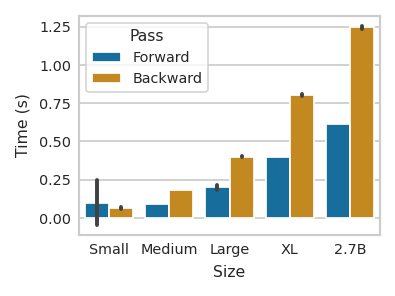

In [8]:
fig, ax = plt.subplots(figsize=(0.45 * LINE, 0.33 * LINE))
sns.barplot(ax=ax, data=df, x="Size", y="Time (s)", hue="Pass", errorbar="sd")
fig.savefig("fig/benchmark_no_warmup.pdf", bbox_inches="tight")
fig.show()

## with warmup

In [10]:
out = {}
for size, d_model, d_ff, num_layers, num_heads in [
    ("Small", 768, 3072, 12, 12),
    ("Medium", 1024, 4096, 24, 16),
    ("Large", 1280, 5120, 36, 20),
    ("XL", 1600, 6400, 48, 25),
    ("2.7B", 2560, 10240, 32, 32),
]:
    fw_time, bw_time = benchmark.main(
        SimpleNamespace(
            vocab_size=10_000,
            context_length=128,
            d_model=d_model,
            num_layers=num_layers,
            num_heads=num_heads,
            d_ff=d_ff,
            attn_pdrop=0.0,
            residual_pdrop=0.0,
            batch_size=16,
            warmup_steps=1,
            benchmark_steps=5,
        )
    )
    out[size] = fw_time, bw_time

=== Forward ===
All:	tensor([0.0363, 0.0303, 0.0303, 0.0303, 0.0304])
Mean:	3.15e-02
Std:	2.66e-03
=== Backward ===
All:	tensor([0.0713, 0.0608, 0.0609, 0.0608, 0.0606])
Mean:	6.29e-02
Std:	4.72e-03
=== Forward ===
All:	tensor([0.0907, 0.0903, 0.0904, 0.0905, 0.0904])
Mean:	9.05e-02
Std:	1.66e-04
=== Backward ===
All:	tensor([0.1830, 0.1830, 0.1830, 0.1829, 0.1829])
Mean:	1.83e-01
Std:	4.51e-05
=== Forward ===
All:	tensor([0.1934, 0.1946, 0.1934, 0.1939, 0.1933])
Mean:	1.94e-01
Std:	5.51e-04
=== Backward ===
All:	tensor([0.4009, 0.4008, 0.4019, 0.4028, 0.4066])
Mean:	4.03e-01
Std:	2.38e-03
=== Forward ===
All:	tensor([0.4003, 0.3998, 0.4005, 0.4005, 0.3992])
Mean:	4.00e-01
Std:	5.56e-04
=== Backward ===
All:	tensor([0.8033, 0.8040, 0.8038, 0.8052, 0.8064])
Mean:	8.05e-01
Std:	1.23e-03
=== Forward ===
All:	tensor([0.6157, 0.6160, 0.6177, 0.6166, 0.6168])
Mean:	6.17e-01
Std:	7.68e-04
=== Backward ===
All:	tensor([1.2467, 1.2509, 1.2521, 1.2520, 1.2546])
Mean:	1.25e+00
Std:	2.87e-03


In [11]:
for size, (fw_time, bw_time) in out.items():
    print(f"=== {size} ===")
    print(f"  Forward:  {fw_time}")
    print(f"  Backward: {bw_time}")

=== Small ===
  Forward:  tensor([0.0363, 0.0303, 0.0303, 0.0303, 0.0304])
  Backward: tensor([0.0713, 0.0608, 0.0609, 0.0608, 0.0606])
=== Medium ===
  Forward:  tensor([0.0907, 0.0903, 0.0904, 0.0905, 0.0904])
  Backward: tensor([0.1830, 0.1830, 0.1830, 0.1829, 0.1829])
=== Large ===
  Forward:  tensor([0.1934, 0.1946, 0.1934, 0.1939, 0.1933])
  Backward: tensor([0.4009, 0.4008, 0.4019, 0.4028, 0.4066])
=== XL ===
  Forward:  tensor([0.4003, 0.3998, 0.4005, 0.4005, 0.3992])
  Backward: tensor([0.8033, 0.8040, 0.8038, 0.8052, 0.8064])
=== 2.7B ===
  Forward:  tensor([0.6157, 0.6160, 0.6177, 0.6166, 0.6168])
  Backward: tensor([1.2467, 1.2509, 1.2521, 1.2520, 1.2546])


In [12]:
df = []
for size, (fw_time, bw_time) in out.items():
    for i in range(len(fw_time)):
        df.append({"Size": size, "Pass": "Forward", "Time (s)": fw_time[i].item()})
        df.append({"Size": size, "Pass": "Backward", "Time (s)": bw_time[i].item()})
df = pd.DataFrame(df)
df

,Size,Pass,Time (s)
0,Small,Forward,0.036268
1,Small,Backward,0.071321
2,Small,Forward,0.030309
3,Small,Backward,0.060833
4,Small,Forward,0.030313
5,Small,Backward,0.060853
6,Small,Forward,0.030277
7,Small,Backward,0.060751
8,Small,Forward,0.030379
9,Small,Backward,0.060640


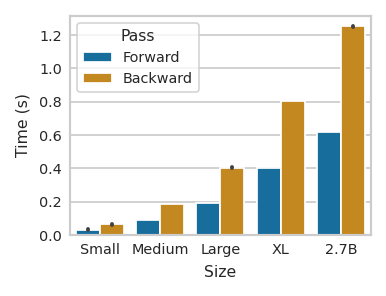

In [18]:
fig, ax = plt.subplots(figsize=(0.45 * LINE, 0.33 * LINE))
sns.barplot(ax=ax, data=df, x="Size", y="Time (s)", hue="Pass", errorbar="sd")
fig.savefig("fig/benchmark_warmup.pdf", bbox_inches="tight")
fig.show()